In [2]:
import pandas as pd
import numpy as np

In [4]:
# stardard the dataset - outcome df_standard
df = pd.read_csv('df_lockmark.csv')
df.columns
df_copy = df[[#'Unnamed: 0', 
    'DateTime', 'posX', #'posY', 
    'posZ', 
    #'rotX', 'rotY', 'rotZ', 
    'taskState', 
    'mapInteractions', 'participant', 'scenario',
       'start_point', #'state', 
       'phase', 'routename', 'taskId', #'lockscreen'
       ]].copy()

filtered_df = df_copy[(df_copy['phase'] == 'navigation') ]

filtered_df = filtered_df.sort_values(by=['participant', 'scenario', 'taskId'])


df_result_standard = pd.read_csv('result_standard.csv')

#add trajectory Id
merged_df = pd.merge(filtered_df, df_result_standard[['participant', 'scenario', 'taskId', 'trajectory_Id']],
                     on=['participant', 'scenario', 'taskId'], how='left')


merged_df.to_csv('df_standard.csv')




In [1]:
# remove the wrong screenunlock
import pandas as pd
import numpy as np

# Assuming df is your DataFrame containing the dataset
df = pd.read_csv('df_standard.csv')
df = df.fillna('')

# # Initialize a list to store distances
# distances = []

# # Iterate over each trajectory_Id
# for trajectory_id, group_data in df.groupby('trajectory_Id'):
#     checked_in_point = group_data[group_data['taskState'].str.contains('checkedIn')].iloc[0]
#     screen_unlock_points = group_data[group_data['mapInteractions'] == 'mapLog:isScreenLocked+False']
    
#     if not screen_unlock_points.empty:
#         last_screen_unlock_point = screen_unlock_points.iloc[-1]
#         distance = np.linalg.norm([checked_in_point['posX'] - last_screen_unlock_point['posX'], 
#                                    checked_in_point['posZ'] - last_screen_unlock_point['posZ']])
#         distances.append((trajectory_id, distance))

# # Create a DataFrame from the distances list
# distance_df = pd.DataFrame(distances, columns=['trajectory_Id', 'distance_to_end'])

# # Display the DataFrame
# print(distance_df)


# Initialize a Series to store distances
distances = pd.Series()

# Iterate over each trajectory_Id
for trajectory_id, group_data in df.groupby('trajectory_Id'):
    checked_in_point = group_data[group_data['taskState'].str.contains('checkedIn')].iloc[0]
    screen_unlock_points = group_data[group_data['mapInteractions'] == 'mapLog:isScreenLocked+False']
    
    if not screen_unlock_points.empty:
        last_screen_unlock_index = screen_unlock_points.index[-1]  # Get the index of the last occurrence
        last_screen_unlock_point = screen_unlock_points.loc[last_screen_unlock_index]
        distance = np.linalg.norm([checked_in_point['posX'] - last_screen_unlock_point['posX'], 
                                   checked_in_point['posZ'] - last_screen_unlock_point['posZ']])
        distances.at[last_screen_unlock_index] = distance  # Store the distance for the last screen unlock point

# Add a new column to the DataFrame to store the distances
df['distance_to_end'] = distances

# Replace 'mapInteractions' value with an empty string if the distance is less than 5
df.loc[df['distance_to_end'] < 5, 'mapInteractions'] = ''

# Display the updated DataFrame
# print(df)

num_less_than_5 = (df['distance_to_end'] < 5).sum()

# Display the result
print("Number of 'distance_to_end' values less than 5:", num_less_than_5)

C:\Users\xuzhengfang\AppData\Local\Temp\ipykernel_22976\2881039664.py:31: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distances = pd.Series()


Number of 'distance_to_end' values less than 5: 625


In [2]:
df.to_csv('df_standard1.csv')

In [ ]:
# standard the result
df = pd.read_csv('result_length.csv')
df.columns
df_copy = df[[#'Unnamed: 0', 
    'participant', 'scenario', 'taskId', #'planning_distance',
       'navigating_distance', 'numScreenLockEvents']].copy()

df_copy['trajectory_Id'] = df.index +1

df_copy.to_csv('result_standard.csv')

feature analysis

In [ ]:
# try Douglas 
import pandas as pd
import numpy as np
from rdp import rdp
import matplotlib.pyplot as plt

df = pd.read_csv('df_standard.csv')

df_tone = df[df['trajectory_Id'] == 23]

posX_array = df_tone['posX'].values
posZ_array = df_tone['posZ'].values

# _____ Prepare for Douglas algorithm 
coordinates = np.column_stack((posX_array, posZ_array))

# Apply RDP (Douglas-Peucker) algorithm to simplify the trajectory coordinates
epsilon = 8
simplified_coordinates = rdp(coordinates, epsilon)

# Extract simplified posX and posZ arrays from the simplified coordinates
simplified_posX = simplified_coordinates[:, 0]
simplified_posZ = simplified_coordinates[:, 1]

directions = np.diff(simplified_coordinates, axis=0)

def calculate_angle(v1, v2):
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(np.clip(cos_theta, -1, 1))

angles = []
for i in range(len(directions) - 1):
    angle = calculate_angle(directions[i], directions[i+1])
    angles.append(np.degrees(angle))

threshold_angle = 29  # Adjust as needed
num_turns = sum(angle > threshold_angle for angle in angles)

print("Number of turns in the simplified trajectory:", num_turns)

# Plot original trajectory
plt.figure(figsize=(8, 6))
plt.plot(posX_array, posZ_array, label='Original Trajectory', color='blue')

# Plot simplified trajectory
plt.plot(simplified_posX, simplified_posZ, label='Simplified Trajectory', color='red', linestyle='--')

# Customize plot
plt.title('Original vs. Simplified Trajectory')
plt.xlabel('posX')
plt.ylabel('posZ')
plt.legend()
plt.grid(True)

# Show plot
plt.show()



In [ ]:
# apply Douglas 
import pandas as pd
import numpy as np
from rdp import rdp

# Function to calculate turns for a given trajectory
def calculate_num_turns(df, trajectory_id, epsilon=8, threshold_angle=29):
    # Filter DataFrame for the specific trajectory_id
    df_tone = df[df['trajectory_Id'] == trajectory_id]
    
    # Extract posX and posZ arrays for the trajectory
    posX_array = df_tone['posX'].values
    posZ_array = df_tone['posZ'].values
    
    # Prepare coordinates for Douglas-Peucker algorithm
    coordinates = np.column_stack((posX_array, posZ_array))
    
    # Apply RDP (Douglas-Peucker) algorithm to simplify the trajectory coordinates
    simplified_coordinates = rdp(coordinates, epsilon)
    
    # Calculate direction vectors
    directions = np.diff(simplified_coordinates, axis=0)
    
    # Function to calculate angle between two vectors
    def calculate_angle(v1, v2):
        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        return np.arccos(np.clip(cos_theta, -1, 1))
    
    # Calculate angles between consecutive direction vectors
    angles = []
    for i in range(len(directions) - 1):
        angle = calculate_angle(directions[i], directions[i+1])
        angles.append(np.degrees(angle))
    
    # Count number of turns based on threshold angle
    num_turns = sum(angle > threshold_angle for angle in angles)
    
    return num_turns

# Read the DataFrame containing trajectory data
df_standard = pd.read_csv('df_standard.csv')

# Get unique trajectory_Id values
unique_trajectory_ids = df_standard['trajectory_Id'].unique()

# Create a list to store results
results = []

# Iterate over each unique trajectory_Id
for trajectory_id in unique_trajectory_ids:
    # Calculate number of turns for the current trajectory_Id
    num_turns = calculate_num_turns(df_standard, trajectory_id)
    
    # Append result to the list
    results.append({'trajectory_Id': trajectory_id, 'num_turns': num_turns})

# Create a new DataFrame from the results list
results_df = pd.DataFrame(results)

# Display the resulting DataFrame
print(results_df)

results_df.to_csv('result_turns.csv')


In [ ]:
## combine the data
results_turns = pd.read_csv('result_turns.csv')
results_standard = pd.read_csv('result_standard.csv')
results_standard_length_turn = pd.merge(results_standard, results_turns, on = 'trajectory_Id', how = 'inner')
results_standard_length_turn.columns
results_standard_length_turn.drop(['Unnamed: 0_x','Unnamed: 0_y'], axis=1, inplace=True)

results_standard_length_turn.to_csv('results_standard_length_turn.csv')

In [ ]:
# correlation for length
df = pd.read_csv('results_standard_length_turn.csv')

# Assuming df is your DataFrame containing the relevant columns
correlation_coefficient = df['navigating_distance'].corr(df['numScreenLockEvents'])

print("Pearson Correlation Coefficient:", correlation_coefficient)

from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(df['navigating_distance'], df['numScreenLockEvents'])

print("Pearson Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

In [ ]:
# correlation for number of turns
df = pd.read_csv('results_standard_length_turn.csv')

# Assuming df is your DataFrame containing the relevant columns
correlation_coefficient = df['num_turns'].corr(df['numScreenLockEvents'])

print("Pearson Correlation Coefficient:", correlation_coefficient)

from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(df['num_turns'], df['numScreenLockEvents'])

print("Pearson Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

In [ ]:
# regression analysis of length
import statsmodels.api as sm

# Prepare data (X and y)
X = df['navigating_distance']
y = df['numScreenLockEvents']

# Fit regression model
X = sm.add_constant(X)  # Add intercept
model = sm.OLS(y, X)
results = model.fit()

# Print regression summary
print(results.summary())

In [ ]:
# regression analysis of num_turns
import statsmodels.api as sm

# Prepare data (X and y)
X = df['num_turns']
y = df['numScreenLockEvents']

# Fit regression model
X = sm.add_constant(X)  # Add intercept
model = sm.OLS(y, X)
results = model.fit()

# Print regression summary
print(results.summary())

In [ ]:
# mutiple linear regression
# regression analysis of num_turns
import statsmodels.api as sm

# Prepare data (X and y)
X = df[['navigating_distance', 'num_turns']]
y = df['numScreenLockEvents']

# Fit regression model
X = sm.add_constant(X)  # Add intercept
model = sm.OLS(y, X)
results = model.fit()

# Print regression summary
print(results.summary())

In [ ]:
# machine learning model of length 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare data (X and y)
X = df[['length', 'num_turns']]
y = df['num_unlock']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
# Print the intercept and coefficient
print("Intercept (beta0):", model.intercept_)
print("Coefficient (beta1):",  model.coef_)


import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Identity line
plt.xlabel('Actual numScreenLockEvents')
plt.ylabel('Predicted numScreenLockEvents')
plt.title('Actual vs. Predicted values')
plt.show()



In [ ]:
#scatter plot to find out whether it is linear 
import matplotlib.pyplot as plt

# Example scatter plot for navigating_distance vs. numScreenLockEvents
plt.figure(figsize=(8, 6))
plt.scatter(df['num_turns'], df['numScreenLockEvents'], alpha=0.5)
plt.xlabel('Navigating Distance')
plt.ylabel('numScreenLockEvents')
plt.title('Scatter Plot: Navigating Distance vs. numScreenLockEvents')
plt.show()


In [ ]:
# create poi array 
poi_locations = [
    (-766.9, -894.9),  # park
    (-392.58, -1157.71),  
    (-817.57, -601.99),
    (-1081.57, -1108.19),
    (-28.1,-596.01),

    (-1101.88, -577.52), #sport
    (-332.63, -614.75),
    (-159.9, -1143),
    (-1045.44, -1200.75),

    (-625.14, -838.87), #coffee
    (-840.25,-856.37),
    (-820.96, -748.96),
    (-613.59, -970.7),
    (-419.13, -908.99),
    (-490.15, -652.47),
    (-238.3, -701.68),
    (-361.04, -860.41),
    (-830.88, -947.93),
    (-719.97, -1044.14),
    (-819.52, -1145.86),
    (-1073.3, -1018.81),
    (-974.22, -712.57),
    (-274.53, -1014.45),
    (-520.1, -1055.37),
    (-336.82, -1144.02),
    (-118.01, -1017.54), 

    (-743.73, -840.01), #restaurant 
    (-458.03, -840.94),
    (-738.03, -717.71),
    (-496.14, -1012.08),
    (-884.22, -1119.09),
    (-929.01, -919.32),
    (-263.49, -899.94),
    (-362.24, -705.03),
    (-222.91, -745.45),
    (-121.73, -844.43),
    (-1064.33, -766.6),
    (-1182.02, -917.85),
    (-119.73, -1044.94),
    (-295.25, -1115.23),
    (-636.91, -1191.63),
    (-1035.66, -891),
    (-540.14, -752.89),

    (-538.08, -915.83), #supermarket 
    (-738.87, -794.57),
    (-917.878, -1143.45),
    (-562.46, -1193.95),
    (-32.35, -824.06),
    (-228.02, -644.17),
    (-1162.22, -964.19),
    (-513.93, -518.5),
    (-701.29, -1015.61),
    (-920.69, -619.16),
    (-667.31, -717.89),
    (-980.44, -794.67),
    (-178.99, -1044.27),
    (-355.9, -1046.17),
    (-367.65, -816.18),

    (-631.33, -915.06), #hotel 
    (-378, -951.05),
    (-537.24, -1201.11),
    (-682.61, -1118.77),
    (-663.27, -1201.01),
    (-1274.03, -1127.92),
    (-1163.82, -841.09),
    (-631.95, -546.78),
    (-547.64, -615.02),
    (-62.93, -942.71),
    (-37.04, -1014.3),
    (-261.32, -663.8),
    (-117.63, -745.75),
    (-933.54, -647.44),
    (-936.83, -964.18),
    (-761.72, -801.4),

    (-1136.89, -660.98), #education 
    (-1125.88, -1343.52),
    (-72.58, -1209.58),
    (-138, -607.13),

    (-321.75, -1054.22), #sight 
    (-644.03, -1127.19),
    (-962.22, -934.38),
    (-1138.01, -838.64),
    (-882.71, -808.23),
    (-643.52, -806.84),
    (-237.39, -932.21),
    (-529.76, -840.47),
    (-336.16, -813.36),
    (-835.11, -712.37),
    (-327.09, -954.83),
    (-482.39, -1047.31),
    (-599.18, -651.9),
    (-418.53, -847.23),
    (-780.73, -903.43),
    (-689.23, -1048.66),
    (-40.66, -1041),
    (-455.45, -966.4),
    (-707.82, -617.67),
    (-697.24, -961.46),
    (-765.65, -1104.88),

    (-445.97, -913.35), #kisok
    (-866.87, -1025.7),
    (-693.02, -840.09),
    (-545.8, -1043.53),
    (-473.96, -719.25),
    (-854.43, -732.3),
    (-550.78, -1128.99),
    (-750.95, -1143.43),
    (-1151.59, -1036.64),
    (-938.92, -758.99),
    (-1162.57, -787.93),
    (-262.34, -810.18),
    (-253.44, -1034.41),
    (-38.21, -799.2),
    (-162.09, -988.04)
]

poi_array = np.array(poi_locations)


In [ ]:
# test poi locations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def plot_poi_on_map(img_path, poi_locations):
    # Load the map image
    img = mpimg.imread(img_path)
    img_height, img_width, _ = img.shape

    # Set map coordinates (same as above)
    center_x, center_z = -594.0938, -936.8522
    bottom_left_x, bottom_left_z = -1349.39, -1655.76
    dist_to_left = center_x - bottom_left_x
    dist_to_top = center_z - bottom_left_z

    # Generate x and y coordinates for the map image
    x = np.linspace(center_x - dist_to_left, center_x + dist_to_left, img_width)
    y = np.linspace(center_z - dist_to_top, center_z + dist_to_top, img_height)
    X, Y = np.meshgrid(x, y)

    # Create the plot with the map image
    plt.figure(figsize=(20, 16))
    plt.imshow(img, extent=[x[0], x[-1], y[0], y[-1]])

    # Plot the POI locations on the map
    poi_x = [poi[0] for poi in poi_locations]
    poi_y = [poi[1] for poi in poi_locations]
    plt.scatter(poi_x, poi_y, color='red', marker='o', s=50, label='Points of Interest')

    # Add labels to the POI locations (optional)
    for i, (px, py) in enumerate(zip(poi_x, poi_y)):
        plt.text(px, py, f'POI {i+1}', color='red', fontsize=8, ha='center', va='bottom')

    # Set plot title and labels
    plt.title('Map with Points of Interest')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')

    # Show legend for the POI locations
    plt.legend()

    # Show the plot
    plt.show()

# Example POI locations
    poi_locations = [
        (-766.9, -894.9),  # Park
        (-392.58, -1157.71),
        (-817.57, -601.99),
        (-1081.57, -1108.19),
        (-28.1, -596.01)
    ]

# Path to the map image file
img_path = 'map_vector_v3_icons.png'

# Plot the map with POI locations
plot_poi_on_map(img_path, poi_locations)


In [ ]:
# calculate the pois for each trajectory
import pandas as pd
from shapely.geometry import LineString, Point
from scipy.spatial import cKDTree

def count_pois_in_buffer(trajectory_data, poi_locations, buffer_radius_km):
    # Extract trajectory coordinates from DataFrame
    posX_data = trajectory_data['posX'].tolist()
    posZ_data = trajectory_data['posZ'].tolist()
    
    # Create a LineString from the trajectory points
    trajectory_line = LineString(zip(posX_data, posZ_data))
    
    # Create a buffer region around the trajectory LineString
    buffer_radius_meters = buffer_radius_km  # Convert km to meters
    trajectory_buffer = trajectory_line.buffer(buffer_radius_meters)
    
    # Create a KDTree for POI locations
    poi_kdtree = cKDTree(poi_locations)
    
    # Initialize a counter for POIs in buffer
    poi_count = 0
    
    # Iterate over each POI location
    for poi in poi_locations:
        # Extract x and z coordinates from the POI location
        x, z = poi
        
        # Check if the POI Point is within the trajectory buffer
        poi_point = Point(x, z)
        if poi_point.within(trajectory_buffer):
            poi_count += 1
    
    return poi_count

# Specify the buffer radius in kilometers
buffer_radius_km = 30  # Adjust as needed

# List to store results for each trajectory_id
results = []

# Iterate over unique trajectory_id values in the DataFrame
for trajectory_id in df['trajectory_Id'].unique():
    # Filter the DataFrame for the current trajectory_id
    trajectory_data = df[df['trajectory_Id'] == trajectory_id]
    
    # Calculate the number of POIs in the buffer around the trajectory
    num_pois_in_buffer = count_pois_in_buffer(trajectory_data, poi_locations, buffer_radius_km)
    
    # Append the result as a dictionary to the results list
    results.append({'trajectory_Id': trajectory_id, 'num_POI': num_pois_in_buffer})

# Create a new DataFrame from the results list
result_df = pd.DataFrame(results)

# Display or process the new DataFrame
print(result_df)

result_df.to_csv('result_POI.csv')



In [ ]:
# plot buffer and poi on base map
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from shapely.geometry import LineString

def plot_trajectory_with_buffer_and_pois(trajectory_data, poi_locations, buffer_radius_km, img_path):
    # Load the map image
    img = mpimg.imread(img_path)
    img_height, img_width, _ = img.shape

    # Set map coordinates (same as above)
    center_x, center_z = -594.0938, -936.8522
    bottom_left_x, bottom_left_z = -1349.39, -1655.76
    dist_to_left = center_x - bottom_left_x
    dist_to_top = center_z - bottom_left_z

    # Generate x and y coordinates for the map image
    x = np.linspace(center_x - dist_to_left, center_x + dist_to_left, img_width)
    y = np.linspace(center_z - dist_to_top, center_z + dist_to_top, img_height)
    X, Y = np.meshgrid(x, y)

    # Create the plot with the map image
    plt.figure(figsize=(20, 16))
    plt.imshow(img, extent=[x[0], x[-1], y[0], y[-1]])

    # Plot the Points of Interest (POIs) on the map
    poi_x = [poi[0] for poi in poi_locations]
    poi_y = [poi[1] for poi in poi_locations]
    plt.scatter(poi_x, poi_y, color='red', marker='o', s=30, label='Points of Interest')

    # Add labels to the POI locations (optional)
    for i, (px, py) in enumerate(zip(poi_x, poi_y)):
        plt.text(px, py, f'POI {i+1}', color='red', fontsize=8, ha='center', va='bottom')

    # Process the trajectory data
    posX_data = trajectory_data['posX'].tolist()
    posZ_data = trajectory_data['posZ'].tolist()

    # Create a LineString from the trajectory points
    trajectory_line = LineString(zip(posX_data, posZ_data))

    # Create a buffer region around the trajectory LineString
    buffer_radius_meters = buffer_radius_km  # Convert km to meters
    trajectory_buffer = trajectory_line.buffer(buffer_radius_meters)

    # Extract x and y coordinates from the LineString and buffer
    x_traj, y_traj = trajectory_line.xy
    x_buf, y_buf = trajectory_buffer.exterior.xy

    # Plot the trajectory and its buffer on the map
    plt.plot(x_traj, y_traj, label='Trajectory', color='blue', linestyle='-', linewidth=2)
    plt.fill(x_buf, y_buf, alpha=0.3, color='orange', label='Buffer Region')

    # Set plot title and labels
    plt.title('Map with Trajectory and Points of Interest')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')

    # Show legend for the POI locations and trajectory
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.axis('equal')  # Equal scaling on x and y axes
    plt.show()

# Example usage:
# Assuming 'df' is your DataFrame containing the trajectory data
# Replace 'trajectory_data' with the filtered DataFrame for trajectory_id = 1
# Replace 'poi_locations' with the list of POI locations [(x1, y1), (x2, y2), ...]
# Specify the buffer radius in kilometers and the path to the map image ('img_path')

# Define the trajectory data and POI locations (replace with actual data)
df = pd.read_csv('df_standard.csv')
trajectory_data = df[df['trajectory_Id'] == 2]  # Filtered DataFrame for trajectory_id = 1
buffer_radius_km = 30 # Buffer radius in kilometers
img_path = 'map_vector_v3_icons.png'  # Path to the map image

# Plot the trajectory with buffer and POIs on the map
plot_trajectory_with_buffer_and_pois(trajectory_data, poi_locations, buffer_radius_km, img_path)


In [ ]:
## combine the data with POI
result_POI = pd.read_csv('result_POI.csv')
results_standard_length_turn = pd.read_csv('results_standard_length_turn.csv')
results_standard_length_turn_POI = pd.merge(results_standard_length_turn, result_POI, on = 'trajectory_Id', how = 'inner')
results_standard_length_turn_POI.columns
results_standard_length_turn_POI.drop(['Unnamed: 0_x','Unnamed: 0_y'], axis=1, inplace=True)

results_standard_length_turn_POI.to_csv('results_standard_length_turn_POI.csv')

In [ ]:
# linear regression 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset (replace df with your DataFrame)
df = pd.read_csv('results_standard_length_turn_POI.csv')

# Select relevant features and target variable
features = ['navigating_distance', 'num_turns', 'num_POI']
target = 'numScreenLockEvents'

# Split data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (optional but recommended for some models)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Initialize and train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

results = pd.DataFrame({'True Values': y_test, 'Predicted Values': y_pred})
print(results)

# Print the intercept and coefficient
print("Intercept (beta0):", model.intercept_)
print("Coefficient (beta1):",  model.coef_)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


In [80]:
# create road network 
from shapely.geometry import Point, LineString

# Define road network using nodes and edges (graph representation)
nodes = {
    'v11': Point(-1250.9, -651.57),    # E1
    'v12': Point(-1250.9, -1210.7),

    'v21': Point(-1150.9, -550.99),  # E1
    'v22': Point(-1150.9, -1009.71),
    'v23': Point(-1150.9, -1151.07),
    'v24': Point(-1150.9, -1310.3),

    'v31': Point(-1050.9, -449.6),
    'v32': Point(-1050.9, -1131.9),
    'v33': Point(-1050.9, -1332.2),
    'v34': Point(-1050.9, -1417.2),

    'v41': Point(-950.9, -552.3),
    'v42': Point(-950.9, -1013.1),
    'v43': Point(-950.9, -1131.9),
    'v44': Point(-950.9, -1332.2),

    'v51': Point(-850.9, -552.3),
    'v52': Point(-850.9, -712.3),
    'v53': Point(-850.9, -845.5),
    'v54': Point(-850.9, -1017.5),
    'v55': Point(-850.9, -1131.9),
    'v56': Point(-850.9, -1332.2),

    'v61': Point(-750.9, -452.3),
    'v62': Point(-750.9, -531.7),
    'v63': Point(-750.9, -732.4),
    'v64': Point(-750.9, -829.3),
    'v65': Point(-750.9, -1034.4),
    'v66': Point(-750.9, -1131.8),
    'v67': Point(-750.9, -1331.7),
    'v68': Point(-750.9, -1413),

    'v71': Point(-650.9, -1146.7),
    'v72': Point(-650.9, -1315.1),

    'v81': Point(-600.9, -531.7), #symmetric 
    'v82': Point(-600.9, -592.6),
    'v83': Point(-600.9, -672.7),
    'v84': Point(-600.9, -731.8),
    'v85': Point(-600.9, -829.8),
    'v86': Point(-600.9, -1034.1),

    'v-71': Point(-550, -1146.7),
    'v-72': Point(-550, -1315.1),

    'v-61': Point(-450, -452.3),
    'v-62': Point(-450, -531.7),
    'v-63': Point(-450, -732.4),
    'v-64': Point(-450, -829.3),
    'v-65': Point(-450, -1034.4),
    'v-66': Point(-450, -1131.8),
    'v-67': Point(-450, -1331.7),
    'v-68': Point(-450, -1413),

    'v-52': Point(-350, -712.3), 
    'v-51': Point(-350, -552.3),
    'v-53': Point(-350, -845.5),
    'v-54': Point(-350, -1017.5),
    'v-55': Point(-307, -1131.9),
    'v-56': Point(-307, -1332.2),

    'v-41': Point(-250, -552.3),
    'v-42': Point(-250, -1013.1),
    'v-43': Point(-250, -1131.9),
    'v-44': Point(-250, -1332.2),
    
    'v-31': Point(-150, -449.6),
    'v-32': Point(-150, -1131.9),
    'v-33': Point(-150, -1332.2),
    'v-34': Point(-150, -1417.2),

    'v-21': Point(-50, -550.99),  
    'v-22': Point(-50, -1009.71),
    'v-23': Point(-50, -1151.07),
    'v-24': Point(-50, -1310.3),

    'v-11': Point(50, -651.57),   
    'v-12': Point(50, -1210.7), 

    # horizontal   
    'h11': Point(-1030, -432),    
    'h12': Point(-771, -432),
    'h13': Point(-430.8, -432),    
    'h14': Point(-339.5, -432),
    'h15': Point(-260.8, -432),    
    'h16': Point(-167.2, -432),

    'h21': Point(-1132.7, -532),    
    'h22': Point(-966.9, -532),
    'h23': Point(-833.6, -532),    
    'h24': Point(-366.5, -532),
    'h25': Point(-233.3, -532),    
    'h26': Point(-66.7, -532),

    'h31': Point(-1232.3, -632),    
    'h32': Point(-1149.9, -632),
    'h33': Point(-949.7, -632),    
    'h34': Point(-639.7, -632),
    'h35': Point(-561.4, -632),    
    'h36': Point(-249.7, -632),
    'h37': Point(-50, -632),    
    'h38': Point(33, -632),

    'h41': Point(-831.9, -732),    
    'h42': Point(-369.6, -732),
    'h43': Point(-250, -732),    
    'h44': Point(-50, -732),

    'h51': Point(-1149.8, -782),    
    'h52': Point(-950, -782),

    'h61': Point(-834.18, -832),    
    'h62': Point(-362.9, -832),
    'h63': Point(-249.2, -832),    
    'h64': Point(-50, -832),

    'h71': Point(-1250, -932),    
    'h72': Point(-1150, -932),
    'h73': Point(-950, -932),    
    'h74': Point(-250, -932),
    'h75': Point(-50, -932),    
    'h76': Point(50, -932),

    'h81': Point(-1150, -1032),    
    'h82': Point(-950, -1032),
    'h83': Point(-850, -1032),    
    'h84': Point(-350, -1032),
    'h85': Point(-250, -1032),    
    'h86': Point(-50, -1032),

    'h91': Point(-1138.1, -1132),    
    'h92': Point(-666.8, -1132),
    'h93': Point(-536, -1132),    
    'h94': Point(-63.3, -1132),

    'h101': Point(-1234, -1232),    
    'h102': Point(-950, -1232),
    'h103': Point(-850, -1232),    
    'h104': Point(31.8, -1232),

    'h111': Point(-1134.2, -1332),    
    'h112': Point(-665.6, -1332),
    'h113': Point(-534.1, -1332),    
    'h114': Point(-66.8, -1332),

    'h121': Point(-1033.6, -1432),    
    'h122': Point(-766.5, -1432),
    'h123': Point(-434.6, -1432),    
    'h124': Point(-165.4, -1432),

    # circle
    'c11': Point(-628.4, -605.8),    
    'c12': Point(-570.4, -605.8),
    'c13': Point(-570.4, -658.9),    
    'c14': Point(-628.4, -658.9),

    'c21': Point(-329.7, -406.4),    
    'c22': Point(-269.1, -406.4),
    'c23': Point(-269.1, -457.7),    
    'c24': Point(-329.7, -457.7),
    'cc1': Point(-299.9, -392.1),
    'cc2': Point(-299.9, -471.3),


}

# Define road segments as LineString objects between nodes
road_segments = [
    # vertical
    LineString([nodes['v11'], nodes['v12']]),  

    LineString([nodes['v21'], nodes['v22']]),
    LineString([nodes['v23'], nodes['v24']]),  

    LineString([nodes['v31'], nodes['v32']]), 
    LineString([nodes['v33'], nodes['v34']]), 

    LineString([nodes['v41'], nodes['v42']]), 
    LineString([nodes['v43'], nodes['v44']]), 

    LineString([nodes['v51'], nodes['v52']]), 
    LineString([nodes['v53'], nodes['v54']]), 
    LineString([nodes['v55'], nodes['v56']]), 

    LineString([nodes['v61'], nodes['v62']]), 
    LineString([nodes['v63'], nodes['v64']]), 
    LineString([nodes['v65'], nodes['v66']]), 
    LineString([nodes['v67'], nodes['v68']]), 

    LineString([nodes['v71'], nodes['v72']]),  

    
    LineString([nodes['v81'], nodes['v82']]), 
    LineString([nodes['v83'], nodes['v84']]), 
    LineString([nodes['v85'], nodes['v86']]), 

    LineString([nodes['v-11'], nodes['v-12']]),  
    LineString([nodes['v-21'], nodes['v-22']]),
    LineString([nodes['v-23'], nodes['v-24']]),  
    LineString([nodes['v-31'], nodes['v-32']]), 
    LineString([nodes['v-33'], nodes['v-34']]), 
    LineString([nodes['v-41'], nodes['v-42']]), 
    LineString([nodes['v-43'], nodes['v-44']]), 
    LineString([nodes['v-51'], nodes['v-52']]), 
    LineString([nodes['v-53'], nodes['v-54']]), 
    LineString([nodes['v-55'], nodes['v-56']]), 
    LineString([nodes['v-61'], nodes['v-62']]), 
    LineString([nodes['v-63'], nodes['v-64']]), 
    LineString([nodes['v-65'], nodes['v-66']]), 
    LineString([nodes['v-67'], nodes['v-68']]), 
    LineString([nodes['v-71'], nodes['v-72']]),  

    # horizontal 
    LineString([nodes['h11'], nodes['h12']]),  
    LineString([nodes['h13'], nodes['h14']]),  
    LineString([nodes['h15'], nodes['h16']]),  

    LineString([nodes['h21'], nodes['h22']]),  
    LineString([nodes['h23'], nodes['h24']]),  
    LineString([nodes['h25'], nodes['h26']]),  

    LineString([nodes['h31'], nodes['h32']]),  
    LineString([nodes['h33'], nodes['h34']]),  
    LineString([nodes['h35'], nodes['h36']]), 
    LineString([nodes['h37'], nodes['h38']]),  

    LineString([nodes['h41'], nodes['h42']]),  
    LineString([nodes['h43'], nodes['h44']]),  

    LineString([nodes['h51'], nodes['h52']]),  

    LineString([nodes['h61'], nodes['h62']]),  
    LineString([nodes['h63'], nodes['h64']]),  

    LineString([nodes['h71'], nodes['h72']]),  
    LineString([nodes['h73'], nodes['h74']]),  
    LineString([nodes['h75'], nodes['h76']]), 

    LineString([nodes['h81'], nodes['h82']]),  
    LineString([nodes['h83'], nodes['h84']]),  
    LineString([nodes['h85'], nodes['h86']]), 

    LineString([nodes['h91'], nodes['h92']]),  
    LineString([nodes['h93'], nodes['h94']]),  

    LineString([nodes['h101'], nodes['h102']]),  
    LineString([nodes['h103'], nodes['h104']]),  

    LineString([nodes['h111'], nodes['h112']]),  
    LineString([nodes['h113'], nodes['h114']]),  

    LineString([nodes['h121'], nodes['h122']]),  
    LineString([nodes['h123'], nodes['h124']]),  

    # curve
    LineString([nodes['v11'], nodes['h31']]),  
    LineString([nodes['v12'], nodes['h101']]),

    LineString([nodes['v21'], nodes['h21']]),  
    LineString([nodes['v22'], nodes['h81']]),
    LineString([nodes['v23'], nodes['h91']]),
    LineString([nodes['v24'], nodes['h111']]),

    LineString([nodes['v31'], nodes['h11']]), 
    LineString([nodes['v34'], nodes['h121']]), 

    LineString([nodes['v41'], nodes['h22']]),  
    LineString([nodes['v42'], nodes['h82']]),

    LineString([nodes['v51'], nodes['h23']]),
    LineString([nodes['v52'], nodes['h41']]),
    LineString([nodes['v53'], nodes['h61']]),
    LineString([nodes['v54'], nodes['h83']]),

    LineString([nodes['v61'], nodes['h12']]),
    LineString([nodes['v68'], nodes['h122']]),

    LineString([nodes['v71'], nodes['h92']]),
    LineString([nodes['v72'], nodes['h112']]),

    LineString([nodes['v-71'], nodes['h93']]),
    LineString([nodes['v-72'], nodes['h113']]),

    LineString([nodes['v-61'], nodes['h13']]),
    LineString([nodes['v-68'], nodes['h123']]),

    LineString([nodes['v-51'], nodes['h24']]),
    LineString([nodes['v-52'], nodes['h42']]),
    LineString([nodes['v-53'], nodes['h62']]),
    LineString([nodes['v-54'], nodes['h84']]),

    LineString([nodes['v-41'], nodes['h25']]),  
    LineString([nodes['v-42'], nodes['h85']]),

    LineString([nodes['v-31'], nodes['h16']]), 
    LineString([nodes['v-34'], nodes['h124']]), 

    LineString([nodes['v-21'], nodes['h26']]),  
    LineString([nodes['v-22'], nodes['h86']]),
    LineString([nodes['v-23'], nodes['h94']]),
    LineString([nodes['v-24'], nodes['h114']]),

    LineString([nodes['v-11'], nodes['h38']]),  
    LineString([nodes['v-12'], nodes['h104']]),

    #circle 
    LineString([nodes['h34'], nodes['c11']]),  
    LineString([nodes['c11'], nodes['v82']]),  
    LineString([nodes['v82'], nodes['c12']]),  
    LineString([nodes['c12'], nodes['h35']]),  
    LineString([nodes['h35'], nodes['c13']]),  
    LineString([nodes['c13'], nodes['v83']]),  
    LineString([nodes['v83'], nodes['c14']]),  
    LineString([nodes['c14'], nodes['h34']]), 

    LineString([nodes['h14'], nodes['c21']]),  
    LineString([nodes['c21'], nodes['cc1']]),  
    LineString([nodes['cc1'], nodes['c22']]),  
    LineString([nodes['c22'], nodes['h15']]),  
    LineString([nodes['h15'], nodes['c23']]),  
    LineString([nodes['c23'], nodes['cc2']]),  
    LineString([nodes['cc2'], nodes['c24']]),  
    LineString([nodes['c24'], nodes['h14']]),   






]

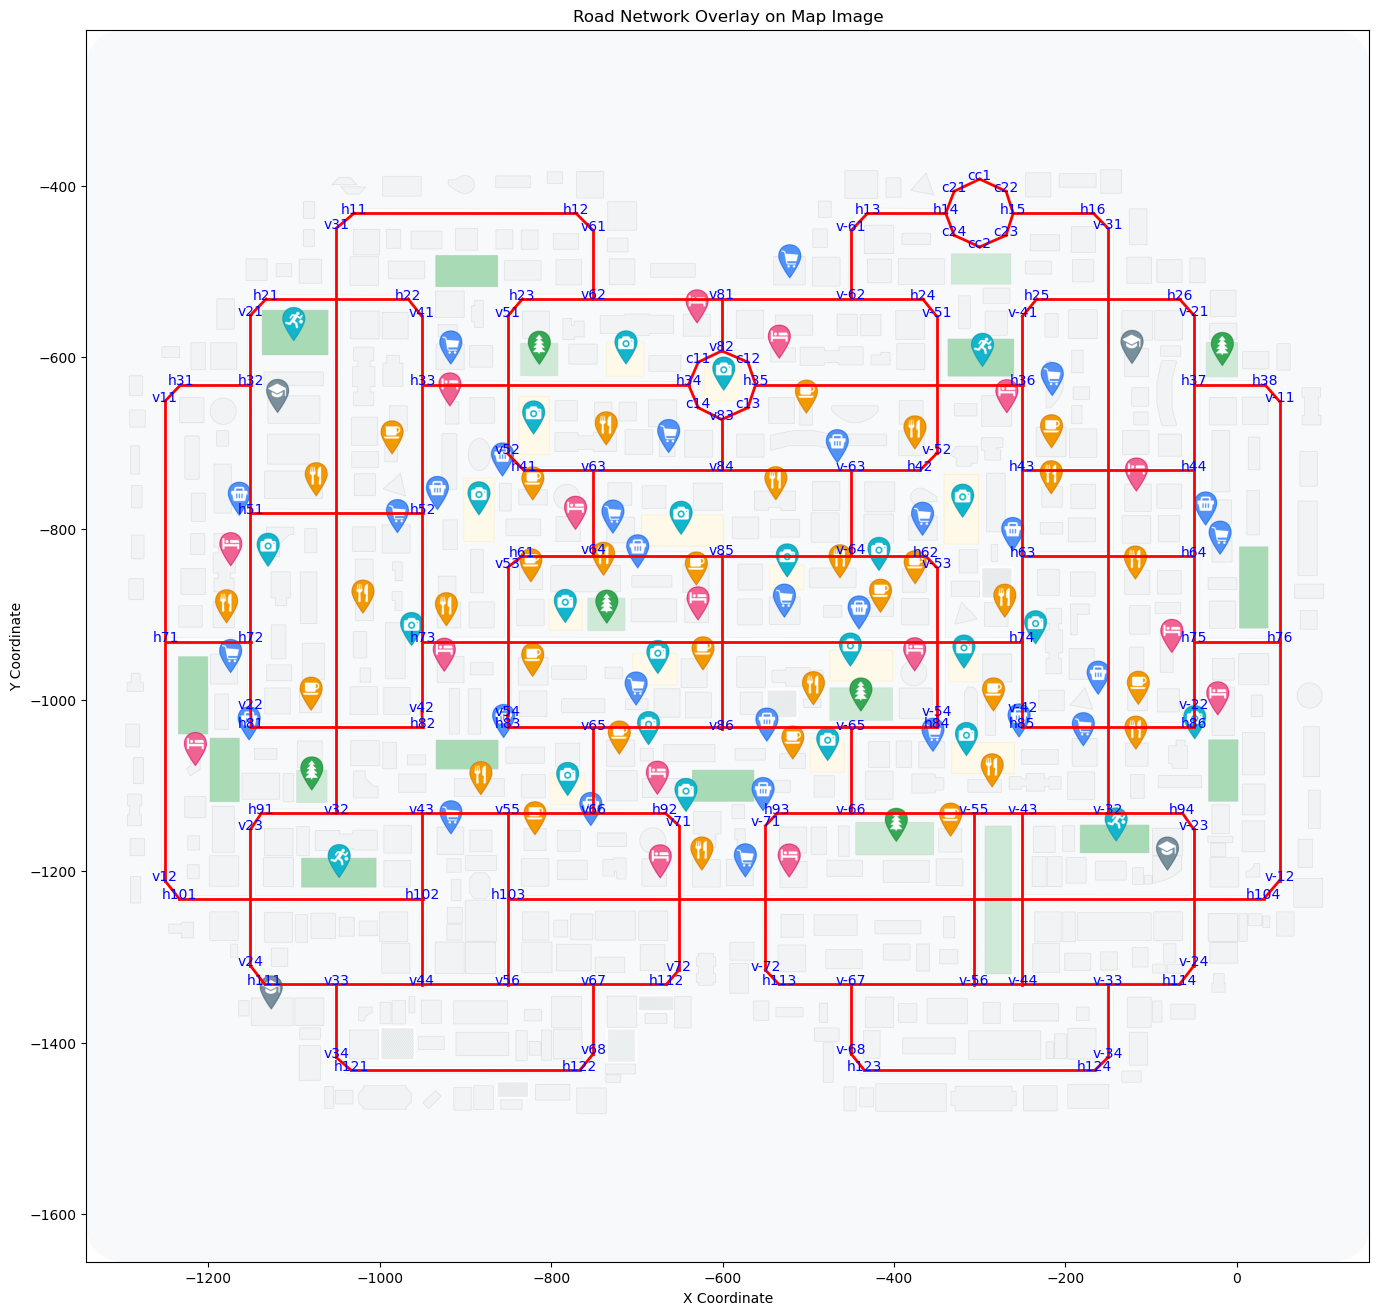

In [100]:
# plot segments on base map
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry import Point, LineString

# Load the map image
img_path = 'map_vector_v3_icons.png'
img = mpimg.imread(img_path)
img_height, img_width, _ = img.shape

# Set map coordinates and plot dimensions
center_x, center_z = -593.7, -936.7
bottom_left_x, bottom_left_z = -1342.4, -1655.6
dist_to_left = center_x - bottom_left_x
dist_to_top = center_z - bottom_left_z

# Generate x and y coordinates for the map image
x = np.linspace(center_x - dist_to_left, center_x + dist_to_left, img_width)
y = np.linspace(center_z - dist_to_top, center_z + dist_to_top, img_height)
X, Y = np.meshgrid(x, y)

# Create the plot with the map image
plt.figure(figsize=(20, 16))
plt.imshow(img, extent=[x[0], x[-1], y[0], y[-1]])

# nodes and segments

# Plot road segments on top of the map image
for road_segment in road_segments:
    # Extract x and y coordinates from LineString
    x_coords, y_coords = road_segment.xy
    
    # Plot LineString on the map image plot
    plt.plot(x_coords, y_coords, 'r-', linewidth=2)  # 'r-' for red lines

for node_name, node_point in nodes.items():
    plt.text(node_point.x, node_point.y, node_name, fontsize=10, color='blue', ha='center')


# Set plot title and axis labels
plt.title('Road Network Overlay on Map Image')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Show the plot
plt.show()


In [ ]:
# calculate num of crossing road for each trajectory
import pandas as pd
from shapely.geometry import Point, LineString

# Load trajectory data from CSV or DataFrame (replace 'df_standard.csv' with your file path)
trajectory_data = pd.read_csv('df_standard.csv')

# Initialize lists to store results
trajectory_ids = []
intersection_counts = []

# Iterate through unique trajectory_Id values
for traj_id in trajectory_data['trajectory_Id'].unique():
    # Filter trajectory data for current trajectory_Id
    trajectory = trajectory_data[trajectory_data['trajectory_Id'] == traj_id]
    
    # Extract trajectory coordinates
    posX_data = trajectory['posX'].tolist()
    posZ_data = trajectory['posZ'].tolist()
    
    # Create LineString from trajectory points
    trajectory_line = LineString(zip(posX_data, posZ_data))
    
    # Calculate intersections with road network
    intersection_count = count_intersections(trajectory_line, road_segments)
    
    # Store results in lists
    trajectory_ids.append(traj_id)
    intersection_counts.append(intersection_count)

# Create DataFrame from collected data
intersection_df = pd.DataFrame({
    'trajectory_Id': trajectory_ids,
    'num_crossroad': intersection_counts
})

# Display the new DataFrame
print(intersection_df)

intersection_df.to_csv('result_cross.csv')


In [ ]:
## combine the data with before
result_cross = pd.read_csv('result_cross.csv')
results_standard_length_turn_POI = pd.read_csv('results_standard_length_turn_POI.csv')
results_standard_length_turn_POI_cross = pd.merge(results_standard_length_turn_POI, result_cross, on = 'trajectory_Id', how = 'inner')
results_standard_length_turn_POI_cross.drop(['Unnamed: 0_x','Unnamed: 0_y'], axis=1, inplace=True)
results_standard_length_turn_POI_cross = results_standard_length_turn_POI_cross.rename(columns= {'navigating_distance' : 'length',
                                                                                                 'numScreenLockEvents' : 'num_unlock'})

results_standard_length_turn_POI_cross.columns
results_standard_length_turn_POI_cross.to_csv('results_standard_length_turn_POI_cross.csv')

data visualization

In [ ]:
# feature relationship

df.plot(kind = 'hist', x = 'length' , y = 'num_unlock')

In [ ]:
import seaborn as sns

sns.scatterplot( x= 'length',
                y = 'num_unlock',
                hue='scenario',
                data = df)
plt.show()

In [ ]:
# violin plot of length
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming ve_phase_out_rm_distance is a pandas DataFrame containing your data

# Filter the data for the "navigating" phase
df = pd.read_csv('results_standard_length_turn_POI_cross.csv')
df['scenario'] = df['scenario'].replace({2: 1, 4: 3}).copy()

# Plotting


sns.violinplot(x='scenario', y='length', data=df, inner=None, linewidth=0.5, cut = 0, palette=["#66B887", "#b084bf"])
sns.boxplot(x='scenario', y='length', data=df, width=0.1,  linewidth=1, fliersize=1, boxprops={'zorder': 2},  color='skyblue')

sns.stripplot(x='scenario', y='length', data=df, jitter=True, dodge=True, alpha=0.3, size=5, palette=["#008837", "#7b3294"])

plt.xlabel('length')
plt.ylabel('Grid distance units')
plt.xticks([0, 1], ['Light traffic', 'Heavy traffic'])
plt.legend(title='Traffic conditions', labels=['Low traffic', 'High traffic'], loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# violin plot of num_unlock
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming ve_phase_out_rm_distance is a pandas DataFrame containing your data

# Filter the data for the "navigating" phase
df = pd.read_csv('results_standard_length_turn_POI_cross.csv')
df['scenario'] = df['scenario'].replace({2: 1, 4: 3}).copy()

# Plotting


sns.violinplot(x='scenario', y='num_unlock', data=df, inner=None, linewidth=0.5, cut = 0, palette=["#66B887", "#b084bf"])
sns.boxplot(x='scenario', y='num_unlock', data=df, width=0.1,  linewidth=1, fliersize=1, boxprops={'zorder': 2},  color='skyblue')

sns.stripplot(x='scenario', y='num_unlock', data=df, jitter=True, dodge=True, alpha=0.3, size=5, palette=["#008837", "#7b3294"])

plt.xlabel('Num_unlock')
plt.ylabel('Count')
plt.xticks([0, 1], ['Light traffic', 'Heavy traffic'])
plt.legend(title='Traffic conditions', labels=['Low traffic', 'High traffic'], loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# violin plot of num_POIs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming ve_phase_out_rm_distance is a pandas DataFrame containing your data

# Filter the data for the "navigating" phase
df = pd.read_csv('results_standard_length_turn_POI_cross.csv')
df['scenario'] = df['scenario'].replace({2: 1, 4: 3}).copy()

# Plotting


sns.violinplot(x='scenario', y='num_POI', data=df, inner=None, linewidth=0.5, cut = 0, palette=["#66B887", "#b084bf"])
sns.boxplot(x='scenario', y='num_POI', data=df, width=0.1,  linewidth=1, fliersize=1, boxprops={'zorder': 2},  color='skyblue')

sns.stripplot(x='scenario', y='num_POI', data=df, jitter=True, dodge=True, alpha=0.3, size=5, palette=["#008837", "#7b3294"])

plt.xlabel('Num_POIs')
plt.ylabel('Count')
plt.xticks([0, 1], ['Light traffic', 'Heavy traffic'])
plt.legend(title='Traffic conditions', labels=['Low traffic', 'High traffic'], loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# violin plot of num_turns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming ve_phase_out_rm_distance is a pandas DataFrame containing your data

# Filter the data for the "navigating" phase
df = pd.read_csv('results_standard_length_turn_POI_cross.csv')
df['scenario'] = df['scenario'].replace({2: 1, 4: 3}).copy()

# Plotting


sns.violinplot(x='scenario', y='num_turns', data=df, inner=None, linewidth=0.5, cut = 0, palette=["#66B887", "#b084bf"])
sns.boxplot(x='scenario', y='num_turns', data=df, width=0.1,  linewidth=1, fliersize=1, boxprops={'zorder': 2},  color='skyblue')

sns.stripplot(x='scenario', y='num_turns', data=df, jitter=True, dodge=True, alpha=0.3, size=5, palette=["#008837", "#7b3294"])

plt.xlabel('Num_turns')
plt.ylabel('Count')
plt.xticks([0, 1], ['Light traffic', 'Heavy traffic'])
plt.legend(title='Traffic conditions', labels=['Low traffic', 'High traffic'], loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# violin plot of num_crossroad
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming ve_phase_out_rm_distance is a pandas DataFrame containing your data

# Filter the data for the "navigating" phase
df = pd.read_csv('results_standard_length_turn_POI_cross.csv')
df['scenario'] = df['scenario'].replace({2: 1, 4: 3}).copy()

# Plotting


sns.violinplot(x='scenario', y='num_crossroad', data=df, inner=None, linewidth=0.5, cut = 0, palette=["#66B887", "#b084bf"])
sns.boxplot(x='scenario', y='num_crossroad', data=df, width=0.1,  linewidth=1, fliersize=1, boxprops={'zorder': 2},  color='skyblue')

sns.stripplot(x='scenario', y='num_crossroad', data=df, jitter=True, dodge=True, alpha=0.3, size=5, palette=["#008837", "#7b3294"])

plt.xlabel('Num_crossroad')
plt.ylabel('Count')
plt.xticks([0, 1], ['Light traffic', 'Heavy traffic'])
plt.legend(title='Traffic conditions', labels=['Low traffic', 'High traffic'], loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#hist length
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'num_unlock' is the column you want to plot
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(data=df, x='length', color='skyblue')
plt.xlabel('Length')
plt.ylabel('Distance units')
plt.title('Trajectory length')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
#hist num_turns
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'num_unlock' is the column you want to plot
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.countplot(data=df, x='num_turns', color='skyblue')
plt.xlabel('Number of turns')
plt.ylabel('Count')
plt.title('Count of Number of turns')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# #hist POIs
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'num_unlock' is the column you want to plot
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.countplot(data=df, x='num_POI', color='skyblue')
plt.xlabel('Number of POIs')
plt.ylabel('Count')
plt.title('Count of Number of POIs')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# hist unlock
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'num_unlock' is the column you want to plot
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.countplot(data=df, x='num_crossroad', color='skyblue')
plt.xlabel('Number of Crossroad')
plt.ylabel('Count')
plt.title('Count of Number of Crossroad')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

align trjactory to the network

In [80]:
# create road network 2
from shapely.geometry import Point, LineString

# Define road network using nodes and edges (graph representation)
nodes = {
    'v11': Point(-1250.9, -622),    # E1
    'v12': Point(-1250.9, -1240.7),

    'v21': Point(-1150.9, -520.99),  # E1
    'v22': Point(-1150.9, -1039.71),
    'v23': Point(-1150.9, -1121.07),
    'v24': Point(-1150.9, -1340.3),

    'v31': Point(-1050.9, -419.6),
    'v32': Point(-1050.9, -1131.9),
    'v33': Point(-1050.9, -1332.2),
    'v34': Point(-1050.9, -1447.2),

    'v41': Point(-950.9, -522.3),
    'v42': Point(-950.9, -1013.1),
    'v43': Point(-950.9, -1131.9),
    'v44': Point(-950.9, -1332.2),

    'v51': Point(-850.9, -522.3),
    'v52': Point(-850.9, -742.3),
    'v53': Point(-850.9, -815.5),
    'v54': Point(-850.9, -1047.5),
    'v55': Point(-850.9, -1131.9),
    'v56': Point(-850.9, -1332.2),

    'v61': Point(-750.9, -422.3),
    'v62': Point(-750.9, -531.7),
    'v63': Point(-750.9, -732.4),
    'v64': Point(-750.9, -829.3),
    'v65': Point(-750.9, -1034.4),
    'v66': Point(-750.9, -1131.8),
    'v67': Point(-750.9, -1331.7),
    'v68': Point(-750.9, -1443),

    'v71': Point(-650.9, -1116.7),
    'v72': Point(-650.9, -1345.1),

    'v81': Point(-600.9, -531.7), #symmetric 
    'v82': Point(-600.9, -592.6),
    'v83': Point(-600.9, -672.7),
    'v84': Point(-600.9, -731.8),
    'v85': Point(-600.9, -829.8),
    'v86': Point(-600.9, -1034.1),

    'v-71': Point(-550, -1116.7),
    'v-72': Point(-550, -1345.1),

    'v-61': Point(-450, -422.3),
    'v-62': Point(-450, -531.7),
    'v-63': Point(-450, -732.4),
    'v-64': Point(-450, -829.3),
    'v-65': Point(-450, -1034.4),
    'v-66': Point(-450, -1131.8),
    'v-67': Point(-450, -1331.7),
    'v-68': Point(-450, -1443),

    'v-52': Point(-350, -742.3), 
    'v-51': Point(-350, -522.3),
    'v-53': Point(-350, -815.5),
    'v-54': Point(-350, -1047.5),
    'v-55': Point(-307, -1131.9),
    'v-56': Point(-307, -1332.2),

    'v-41': Point(-250, -522.3),
    'v-42': Point(-250, -1043.1),
    'v-43': Point(-250, -1131.9),
    'v-44': Point(-250, -1332.2),
    
    'v-31': Point(-150, -419.6),
    'v-32': Point(-150, -1131.9),
    'v-33': Point(-150, -1332.2),
    'v-34': Point(-150, -1437.2),

    'v-21': Point(-50, -520.99),  
    'v-22': Point(-50, -1034.1),
    'v-23': Point(-50, -1121.07),
    'v-24': Point(-50, -1340.3),

    'v-11': Point(50, -621.57),   
    'v-12': Point(50, -1240.7), 

    # horizontal   
    'h11': Point(-1060, -432),    
    'h12': Point(-741, -432),
    'h13': Point(-460.8, -432),    
    'h14': Point(-339.5, -432),
    'h15': Point(-260.8, -432),    
    'h16': Point(-137.2, -432),

    'h21': Point(-1162.7, -532),    
    'h22': Point(-936.9, -532),
    'h23': Point(-863.6, -532),    
    'h24': Point(-336.5, -532),
    'h25': Point(-263.3, -532),    
    'h26': Point(-36.7, -532),

    'h31': Point(-1262.3, -632),    
    'h32': Point(-1149.9, -632),
    'h33': Point(-949.7, -632),    
    'h34': Point(-639.7, -632),
    'h35': Point(-561.4, -632),    
    'h36': Point(-249.7, -632),
    'h37': Point(-50, -632),    
    'h38': Point(63, -632),

    'h41': Point(-861.9, -732),    
    'h42': Point(-339.6, -732),
    'h43': Point(-250, -732),    
    'h44': Point(-50, -732),

    'h51': Point(-1149.8, -782),    
    'h52': Point(-950, -782),

    'h61': Point(-864.18, -832),    
    'h62': Point(-332.9, -832),
    'h63': Point(-249.2, -832),    
    'h64': Point(-50, -832),

    'h71': Point(-1250, -932),    
    'h72': Point(-1150, -932),
    'h73': Point(-950, -932),    
    'h74': Point(-250, -932),
    'h75': Point(-50, -932),    
    'h76': Point(50, -932),

    'h81': Point(-1150, -1032),    
    'h82': Point(-950, -1032),
    'h83': Point(-870, -1032),    
    'h84': Point(-330, -1032),
    'h85': Point(-270, -1032),    
    'h86': Point(-50, -1034.1),

    'h91': Point(-1168.1, -1132),    
    'h92': Point(-636.8, -1132),
    'h93': Point(-566, -1132),    
    'h94': Point(-33.3, -1132),

    'h101': Point(-1264, -1232),    
    'h102': Point(-950, -1232),
    'h103': Point(-850, -1232),    
    'h104': Point(61.8, -1232),

    'h111': Point(-1164.2, -1332),    
    'h112': Point(-635.6, -1332),
    'h113': Point(-564.1, -1332),    
    'h114': Point(-36.8, -1332),

    'h121': Point(-1063.6, -1432),    
    'h122': Point(-736.5, -1432),
    'h123': Point(-464.6, -1432),    
    'h124': Point(-135.4, -1432),

    # circle
    'c11': Point(-628.4, -605.8),    
    'c12': Point(-570.4, -605.8),
    'c13': Point(-570.4, -658.9),    
    'c14': Point(-628.4, -658.9),

    'c21': Point(-329.7, -406.4),    
    'c22': Point(-269.1, -406.4),
    'c23': Point(-269.1, -457.7),    
    'c24': Point(-329.7, -457.7),
    'cc1': Point(-299.9, -392.1),
    'cc2': Point(-299.9, -471.3),


}

# Define road segments as LineString objects between nodes
road_segments = [
    # vertical
    LineString([nodes['v11'], nodes['v12']]),  

    LineString([nodes['v21'], nodes['v22']]),
    LineString([nodes['v23'], nodes['v24']]),  

    LineString([nodes['v31'], nodes['v32']]), 
    LineString([nodes['v33'], nodes['v34']]), 

    LineString([nodes['v41'], nodes['v42']]), 
    LineString([nodes['v43'], nodes['v44']]), 

    LineString([nodes['v51'], nodes['v52']]), 
    LineString([nodes['v53'], nodes['v54']]), 
    LineString([nodes['v55'], nodes['v56']]), 

    LineString([nodes['v61'], nodes['v62']]), 
    LineString([nodes['v63'], nodes['v64']]), 
    LineString([nodes['v65'], nodes['v66']]), 
    LineString([nodes['v67'], nodes['v68']]), 

    LineString([nodes['v71'], nodes['v72']]),  

    
    LineString([nodes['v81'], nodes['v82']]), 
    LineString([nodes['v83'], nodes['v84']]), 
    LineString([nodes['v85'], nodes['v86']]), 

    LineString([nodes['v-11'], nodes['v-12']]),  
    LineString([nodes['v-21'], nodes['v-22']]),
    LineString([nodes['v-23'], nodes['v-24']]),  
    LineString([nodes['v-31'], nodes['v-32']]), 
    LineString([nodes['v-33'], nodes['v-34']]), 
    LineString([nodes['v-41'], nodes['v-42']]), 
    LineString([nodes['v-43'], nodes['v-44']]), 
    LineString([nodes['v-51'], nodes['v-52']]), 
    LineString([nodes['v-53'], nodes['v-54']]), 
    LineString([nodes['v-55'], nodes['v-56']]), 
    LineString([nodes['v-61'], nodes['v-62']]), 
    LineString([nodes['v-63'], nodes['v-64']]), 
    LineString([nodes['v-65'], nodes['v-66']]), 
    LineString([nodes['v-67'], nodes['v-68']]), 
    LineString([nodes['v-71'], nodes['v-72']]),  

    # horizontal 
    LineString([nodes['h11'], nodes['h12']]),  
    LineString([nodes['h13'], nodes['h14']]),  
    LineString([nodes['h15'], nodes['h16']]),  

    LineString([nodes['h21'], nodes['h22']]),  
    LineString([nodes['h23'], nodes['h24']]),  
    LineString([nodes['h25'], nodes['h26']]),  

    LineString([nodes['h31'], nodes['h32']]),  
    LineString([nodes['h33'], nodes['h34']]),  
    LineString([nodes['h35'], nodes['h36']]), 
    LineString([nodes['h37'], nodes['h38']]),  

    LineString([nodes['h41'], nodes['h42']]),  
    LineString([nodes['h43'], nodes['h44']]),  

    LineString([nodes['h51'], nodes['h52']]),  

    LineString([nodes['h61'], nodes['h62']]),  
    LineString([nodes['h63'], nodes['h64']]),  

    LineString([nodes['h71'], nodes['h72']]),  
    LineString([nodes['h73'], nodes['h74']]),  
    LineString([nodes['h75'], nodes['h76']]), 

    LineString([nodes['h81'], nodes['h82']]),  
    LineString([nodes['h83'], nodes['h84']]),  
    LineString([nodes['h85'], nodes['h86']]), 

    LineString([nodes['h91'], nodes['h92']]),  
    LineString([nodes['h93'], nodes['h94']]),  

    LineString([nodes['h101'], nodes['h102']]),  
    LineString([nodes['h103'], nodes['h104']]),  

    LineString([nodes['h111'], nodes['h112']]),  
    LineString([nodes['h113'], nodes['h114']]),  

    LineString([nodes['h121'], nodes['h122']]),  
    LineString([nodes['h123'], nodes['h124']]),  

    

    #circle 
    LineString([nodes['h34'], nodes['c11']]),  
    LineString([nodes['c11'], nodes['v82']]),  
    LineString([nodes['v82'], nodes['c12']]),  
    LineString([nodes['c12'], nodes['h35']]),  
    LineString([nodes['h35'], nodes['c13']]),  
    LineString([nodes['c13'], nodes['v83']]),  
    LineString([nodes['v83'], nodes['c14']]),  
    LineString([nodes['c14'], nodes['h34']]), 

    LineString([nodes['h14'], nodes['c21']]),  
    LineString([nodes['c21'], nodes['cc1']]),  
    LineString([nodes['cc1'], nodes['c22']]),  
    LineString([nodes['c22'], nodes['h15']]),  
    LineString([nodes['h15'], nodes['c23']]),  
    LineString([nodes['c23'], nodes['cc2']]),  
    LineString([nodes['cc2'], nodes['c24']]),  
    LineString([nodes['c24'], nodes['h14']]),   

]

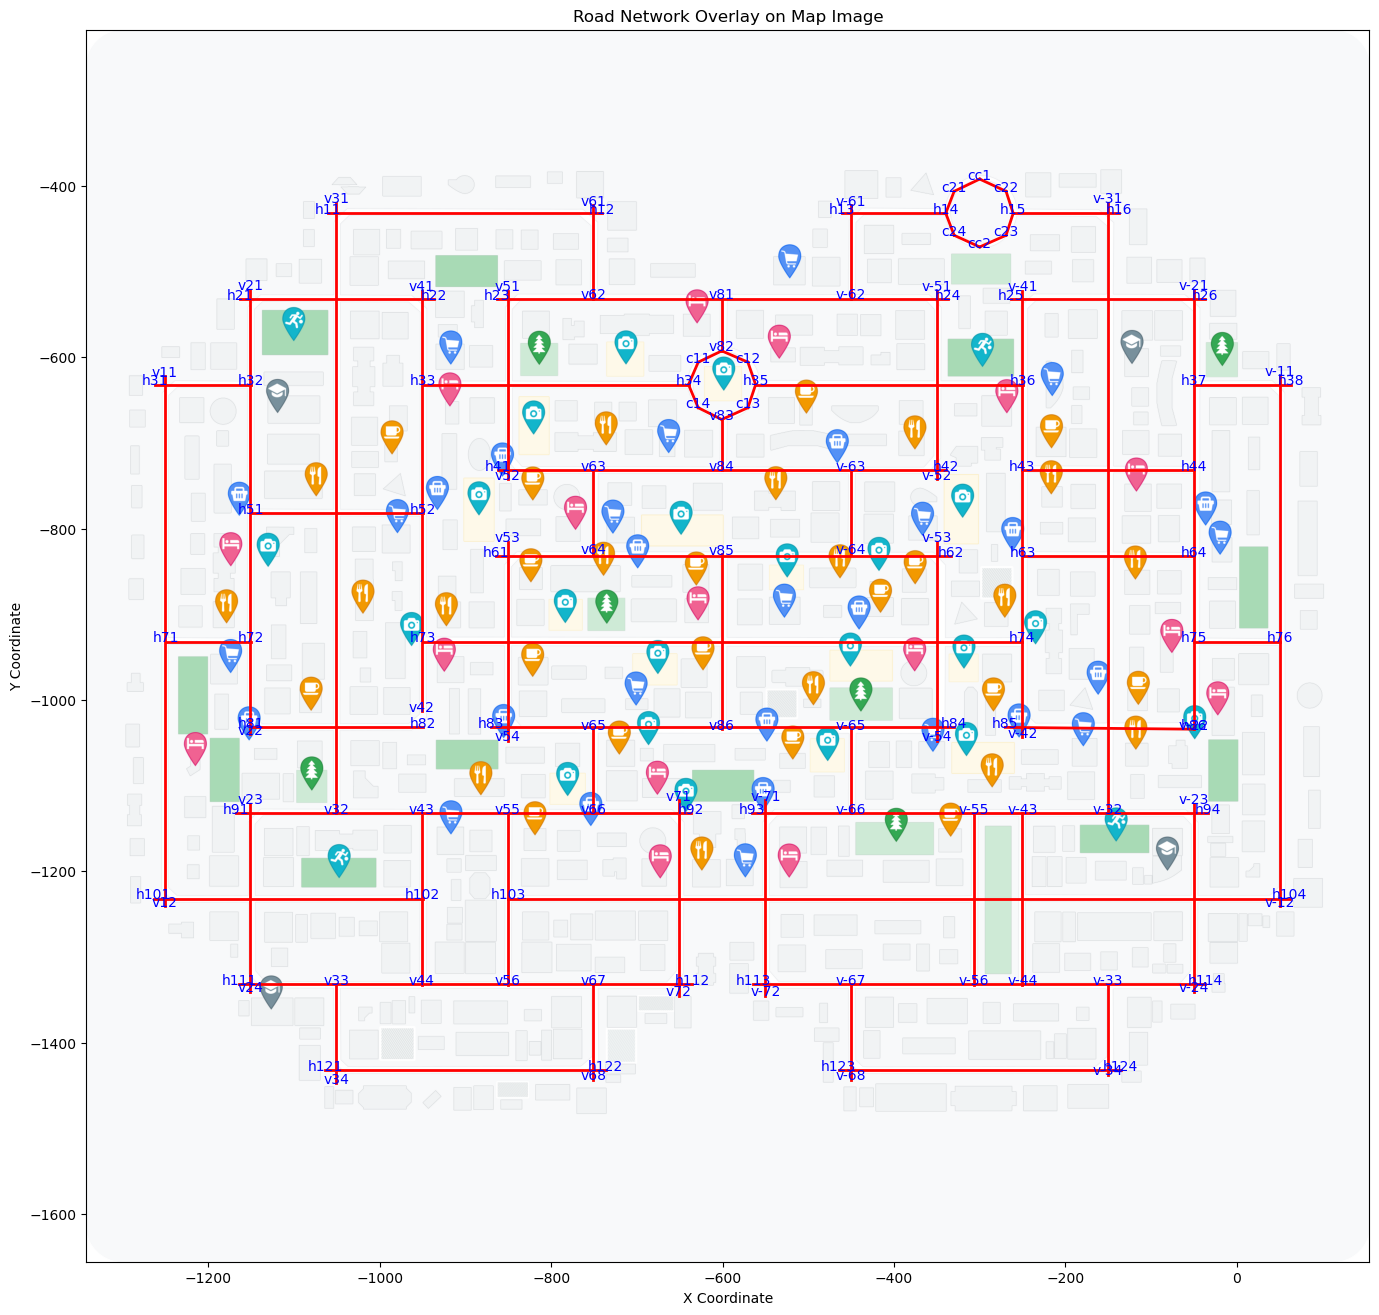

In [81]:
# plot segments 2  on base map
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry import Point, LineString

# Load the map image
img_path = 'map_vector_v3_icons.png'
img = mpimg.imread(img_path)
img_height, img_width, _ = img.shape

# Set map coordinates and plot dimensions
center_x, center_z = -593.7, -936.7
bottom_left_x, bottom_left_z = -1342.4, -1655.6
dist_to_left = center_x - bottom_left_x
dist_to_top = center_z - bottom_left_z

# Generate x and y coordinates for the map image
x = np.linspace(center_x - dist_to_left, center_x + dist_to_left, img_width)
y = np.linspace(center_z - dist_to_top, center_z + dist_to_top, img_height)
X, Y = np.meshgrid(x, y)

# Create the plot with the map image
plt.figure(figsize=(20, 16))
plt.imshow(img, extent=[x[0], x[-1], y[0], y[-1]])

# nodes and segments

# Plot road segments on top of the map image
for road_segment in road_segments:
    # Extract x and y coordinates from LineString
    x_coords, y_coords = road_segment.xy
    
    # Plot LineString on the map image plot
    plt.plot(x_coords, y_coords, 'r-', linewidth=2)  # 'r-' for red lines

for node_name, node_point in nodes.items():
    plt.text(node_point.x, node_point.y, node_name, fontsize=10, color='blue', ha='center')


# Set plot title and axis labels
plt.title('Road Network Overlay on Map Image')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Show the plot
plt.show()
